In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import sys
sys.path.insert(0, '../..')
from src.utils.latex import add_colname, show_latex, TABLES

In [2]:
pd.set_option("max_columns", None)

# Load data

In [3]:
path = Path('../../data/from_inception_tsv')
filenames = [
    'annotated_df_week_14_parsed_dedup.pkl',
    'annotated_df_week_15_parsed_dedup.pkl',
    'annotated_df_week_16_parsed_dedup.pkl',
    'annotated_df_week_17_parsed_dedup.pkl',
]
df = pd.concat([pd.read_pickle(path / fn) for fn in filenames]).assign(
    disregard_note = lambda df: df.groupby('NotitieID').disregard.transform('max'),
)

In [4]:
path = Path('../../data/to_inception_conll')
filenames = [
    'week_14.pkl',
    'week_15.pkl',
    'week_16.pkl',
    'week_17.pkl',
]
info = pd.concat([pd.read_pickle(path / fn) for fn in filenames])

In [5]:
df = df.merge(
    info[['NotitieID', 'MDN', 'source', 'samp_meth']],
    how='left',
    on=['NotitieID', 'MDN'],
)

# Annotated notes

In [6]:
caption = "Weeks 14-17: Number of annotated notes (incl. disregard)"
label = "w14-w17_annot_n_notes"

df.pivot_table(
    index='source',
    values='NotitieID',
    aggfunc='nunique',
    margins=True,
    margins_name='total',
).rename(columns={'NotitieID': 'n_notes'}
).join(
        df.query("disregard == True").pivot_table(
        index='source',
        values='NotitieID',
        aggfunc='nunique',
        margins=True,
        margins_name='total',
    ).rename(columns={'NotitieID': 'n_disregard'})
).assign(
    n_annotated=lambda df: df.n_notes - df.n_disregard,
    prc_disregard=lambda df: (df.n_disregard / df.n_notes).mul(100).round(1),
).pipe(show_latex, caption=caption, label=label)

,n_notes,n_disregard,n_annotated,prc_disregard
source,,,,
2017,231,33,198,14.0
2018,189,28,161,15.0
cov_2020,646,7,639,1.0
non_cov_2020,231,41,190,18.0
total,"1,297",109,"1,188",8.0


# Annotated sentences

In [7]:
# remove "disregard" notes & remove MBW annotations from week 14

adjusted = df.query("disregard_note == False").assign(
    MBW = lambda df: df.MBW.mask(df.batch == 'week_14', other=False),
    MBW_lvl = lambda df: df.MBW_lvl.mask(df.batch == 'week_14'),
)

# select rows with domain labels
domains = ['ENR', 'ATT', 'STM', 'ADM', 'INS', 'MBW', 'FAC', 'BER', 'ETN']
rows_with_domain = adjusted.loc[adjusted[domains].any(axis=1)]
domain_totals_per_sen_id = rows_with_domain.groupby(['source', 'sen_id'])[domains].any()

In [8]:
caption = "Weeks 14-17: Number of sentences with labels (excl. disregard)"
label = "w14-w17_annot_sents_w_labels"

n_sent = adjusted.groupby('source').sen_id.nunique()

n_sent_with_label = adjusted.assign(
    has_domain = lambda df: df[domains].any(axis=1),
).query("has_domain == True").groupby('source').sen_id.nunique()

table = pd.concat([
    n_sent.rename('n_all_sents'),
    n_sent_with_label.rename('n_sents_with_labels'),
], axis=1)
table.loc['total'] = table.sum()
table.assign(prc_sents_with_labels=lambda df: (df.n_sents_with_labels / df.n_all_sents).mul(100).round(1)
).pipe(show_latex, caption=caption, label=label)

,n_all_sents,n_sents_with_labels,prc_sents_with_labels
source,,,
2017,"10,544",510,4.8
2018,"8,145",353,4.3
cov_2020,"34,540","2,326",6.7
non_cov_2020,"11,506",541,4.7
total,"64,735","3,730",5.8


# Distribution of domains

In [9]:
caption = "Weeks 14-17: Distribution of domains"
label = "w14-w17_annot_domains"

n_labels = domain_totals_per_sen_id.pivot_table(
    index='source',
    values=domains,
    aggfunc='sum',
    margins=True,
    margins_name='total',
).assign(total=lambda df: df.sum(axis=1))

p_labels = (n_labels.div(n_labels.iloc[:, -1], axis=0) * 100).round(1)

piv = n_labels.pipe(add_colname, 'n').join(
    p_labels.pipe(add_colname, '%')
).astype('Int64'
).sort_index(axis=1, level=[0,1], ascending=[True, False])

piv.pipe(show_latex, caption=caption, label=label)

ADM     ATT    BER     ENR      ETN      FAC      INS      \
                  n   %   n  %   n  %    n   %    n   %    n   %    n   %   
source                                                                      
2017            143  26  14  3  15  3   55  10   66  12   59  11   54  10   
2018            122  32   5  1  18  5   27   7   39  10   45  12   48  13   
cov_2020      1,238  49  49  2  28  1  186   7  320  13  167   7  233   9   
non_cov_2020    146  25  14  2  12  2   55  10   73  13   58  10   66  11   
total         1,649  41  82  2  73  2  323   8  498  12  329   8  401  10   

              MBW     STM      total       
                n  %    n   %      n    %  
source                                     
2017           28  5  108  20    542  100  
2018           12  3   62  16    378  100  
cov_2020       72  3  220   9  2,513  100  
non_cov_2020   36  6  116  20    576  100  
total         148  4  506  13  4,009  100

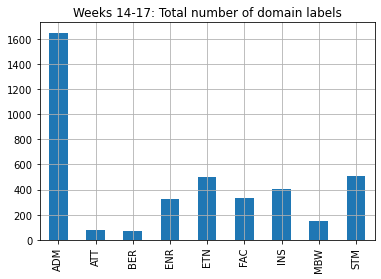

In [10]:
# total number of labels

fig, ax = plt.subplots(figsize=(6, 4))
piv.loc[['total']].xs('n', axis=1, level=1).iloc[:,:-1].T.plot.bar(
    ax=ax,
    legend=False, 
    grid=True, 
    title='Weeks 14-17: Total number of domain labels',
)
fig.savefig('figures/w14-w17_total_n_domains.png')

# Distribution of levels per domain

In [11]:
caption = "Weeks 14-17: Distribution of levels per domain"
label = "w14-w17_annot_levels"

stats = []
for lvl in [f"{i}_lvl" for i in domains]:
    notna = adjusted.loc[adjusted[lvl].notna()]
    stat = notna.groupby(['source', 'sen_id'])[lvl].apply(lambda s: {i for i in s if i==i})
    stat = stat.explode().groupby(level=0).value_counts()
    stats.append(stat)
table = pd.concat(stats, axis=1)
table = table.append(pd.concat([table.groupby(level=1).sum()], keys=['total']))
table.index = pd.MultiIndex.from_tuples([(i,int(j)) for i,j in table.index])
# sums = table.groupby(level=0).sum()
# sums.index = pd.MultiIndex.from_tuples([(i, 'Total') for i in sums.index])
# table = pd.concat([table, sums]).sort_index(level=0)
table.pipe(show_latex, caption=caption, label=label)

ENR_lvl ATT_lvl STM_lvl ADM_lvl INS_lvl MBW_lvl FAC_lvl  \
2017         0     3.0     nan    10.0    12.0       2     3.0       3   
             1     6.0     1.0    19.0    20.0      14     1.0       3   
             2    37.0     6.0    53.0    26.0      20     9.0       1   
             3     7.0     2.0    16.0    27.0      13     6.0      12   
             4     nan     5.0    21.0    69.0       4     9.0      36   
             5     nan     nan     nan     nan       4     nan       4   
2018         0     2.0     2.0     nan     9.0       1     nan       1   
             1     4.0     nan     9.0    13.0       8     nan       1   
             2    19.0     1.0    29.0    17.0      10     2.0       5   
             3     2.0     1.0    14.0    33.0      15     3.0       7   
             4     nan     2.0    10.0    56.0       7     7.0      22   
             5     nan     nan     nan     nan       7     nan      11   
cov_2020     0    11.0     2.0    15.0   198.0      24     3.0      18   
             1    65.0     7.0    27.0   436.0      94    17.0       8   
             2    89.0    18.0   103.0   235.0      66    16.0       6   
             3    17.0     9.0    31.0   232.0      35     6.0      28   
             4     9.0    15.0    60.0   235.0       6    21.0      84   
             5     nan     nan     nan     nan      12     nan      18   
non_cov_2020 0     6.0     1.0     5.0     3.0       7     4.0       4   
             1    14.0     5.0    33.0    30.0       7     4.0       5   
             2    28.0     3.0    41.0    28.0      24     5.0       9   
             3     6.0     2.0    24.0    30.0      14     8.0       8   
             4     7.0     3.0    19.0    70.0       9    14.0      26   
             5     nan     nan     nan     nan      11     nan       5   
total        0    22.0     5.0    30.0   222.0      34    10.0      26   
             1    89.0    13.0    88.0   499.0     123    22.0      17   
             2   173.0    28.0   226.0   306.0     120    32.0      21   
             3    32.0    14.0    85.0   322.0      77    23.0      55   
             4    16.0    25.0   110.0   430.0      26    51.0     168   
             5     0.0     0.0     0.0     0.0      34     0.0      38   

               BER_lvl ETN_lvl  
2017         0     4.0     7.0  
             1     1.0    24.0  
             2     1.0    14.0  
             3     3.0     6.0  
             4     6.0    18.0  
             5     nan     nan  
2018         0     3.0     6.0  
             1     nan    16.0  
             2     3.0     4.0  
             3     nan     nan  
             4    11.0    14.0  
             5     nan     nan  
cov_2020     0    13.0    60.0  
             1     nan    68.0  
             2     5.0    92.0  
             3     1.0    38.0  
             4     8.0    83.0  
             5     nan     nan  
non_cov_2020 0     3.0     8.0  
             1     2.0    13.0  
             2     nan    17.0  
             3     nan    12.0  
             4     4.0    33.0  
             5     nan     nan  
total        0    23.0    81.0  
             1     3.0   121.0  
             2     9.0   127.0  
             3     4.0    56.0  
             4    29.0   148.0  
             5     0.0     0.0

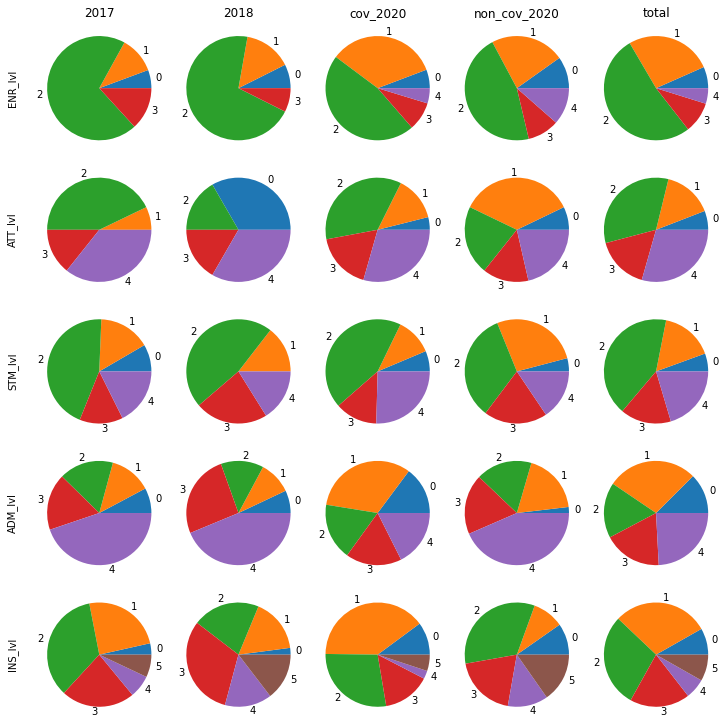

In [12]:
cols = table.index.levels[0]
rows = table.columns[:5]
nrows = len(rows)
ncols = len(cols)
fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows), constrained_layout=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ylabel = row if j == 0 else ''
        table.xs(col)[row].plot.pie(ax=axes[i,j])
        axes[i,j].set_ylabel(ylabel=ylabel, labelpad=16)
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

fig.savefig('figures/w14-w17_levels_part1.png')

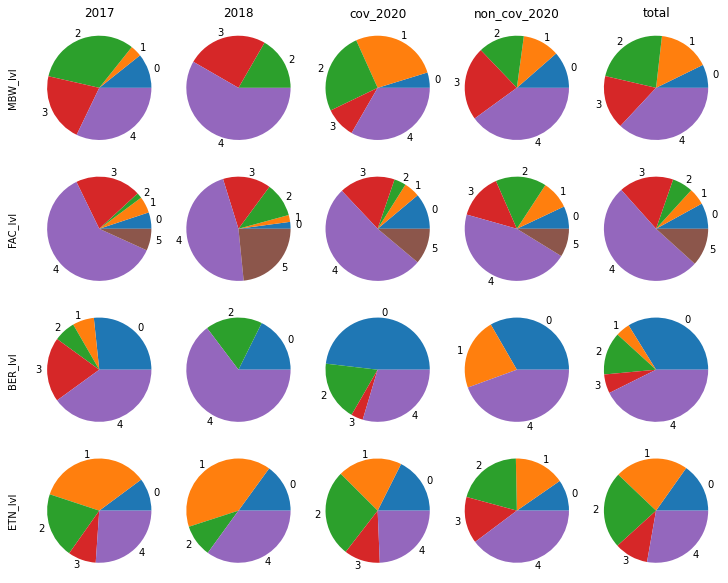

In [13]:
cols = table.index.levels[0]
rows = table.columns[5:]
nrows = len(rows)
ncols = len(cols)
fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows), constrained_layout=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ylabel = row if j == 0 else ''
        table.xs(col)[row].plot.pie(ax=axes[i,j])
        axes[i,j].set_ylabel(ylabel=ylabel, labelpad=16)
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

fig.savefig('figures/w14-w17_levels_part2.png')

# Randomly-selected notes vs. Keyword-selected notes

In [14]:
# % disregard notes (out of all notes)
compare_samp = df.assign(
    samp_meth=lambda df: df.samp_meth.str.split('_').str[0]
).groupby(['samp_meth']).apply(
    lambda grp: grp.groupby('NotitieID').disregard_note.first().agg({'n':'size', 'p':'sum'})
)
pct_disregard = (compare_samp.p / compare_samp.n).mul(100).round(1).rename(r'% disregard notes')

# % sentences with labels (out of all sents, excl. disregard)
adjusted = adjusted.assign(
    samp_meth=lambda df: df.samp_meth.str.split('_').str[0]
)
n_sents = adjusted.groupby('samp_meth').sen_id.nunique()

n_sents_with_label = adjusted.assign(
    has_domain = lambda df: df[domains].any(axis=1),
).query("has_domain == True").groupby('samp_meth').sen_id.nunique()

pct_sents_with_label = (n_sents_with_label / n_sents).mul(100).round(1).rename(r'% sentences with labels')

# distribution of domains
rows_with_domain = adjusted.loc[adjusted[domains].any(axis=1)]
domain_totals_per_sen_id = rows_with_domain.groupby(['samp_meth', 'sen_id'])[domains].any()

n_labels = domain_totals_per_sen_id.pivot_table(
    index='samp_meth',
    values=domains,
    aggfunc='sum',
).assign(total=lambda df: df.sum(axis=1))

pct_labels = (n_labels.div(n_labels.iloc[:, -1], axis=0) * 100).round(1).iloc[:,:-1]

# put everything together
caption = "Weeks 14-17: Comparison between randomly-selected and keyword-selected notes"
label = "w14-w17_annot_kwd_vs_rndm"

pd.concat([pct_disregard, pct_sents_with_label, pct_labels], axis=1).T.pipe(show_latex, caption=caption, label=label)

samp_meth,kwd,rndm
% disregard notes,8.6,7.8
% sentences with labels,5.7,6.7
ADM,40.3,49.4
ATT,2.2,0.6
BER,1.8,2.0
ENR,8.1,8.0
ETN,12.5,11.9
FAC,8.3,6.8
INS,10.3,7.4
MBW,3.9,1.1


In [15]:
prefix = 'w14-w17_annot'
for idx, table in enumerate(TABLES):
    with open(f'./tables/{prefix}_{idx}.tex', 'w', encoding='utf8') as f:
        f.write(table)